## Implementation2

In [2]:
println(readall("lin_interp2.jl"))

immutable lin_interp2
    grid::Array
    vals::Array
end

function Base.call(points::lin_interp2, x::Real)
    i = searchsortedlast(grid, x)
    if i == 0 || i == length(grid)
        return 0
    end
    x_i = points.grid[i]
    x_j = points.grid[i + 1]
    y_i = points.vals[i]
    y_j = points.vals[i + 1]
        
    y = y_i + (y_j - y_i) * ((x - x_i) / (x_j - x_i))
    return y
end

function Base.call{T<:Real}(points::lin_interp2, x::AbstractVector{T})
    n = length(x)
    out = Array(Float64, n)
    for t in 1:n
        out[t] = points(x[t])
    end
    return out
end


In [3]:
#=
Solving the optimal growth problem via value function iteration.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date : 2014-07-05

References
----------

Simple port of the file quantecon.models.optgrowth

http://quant-econ.net/jl/dp_intro.html
=#

#=
    This type defines the primitives representing the growth model. The
    default values are

        f(k) = k**alpha, i.e, Cobb-Douglas production function
        u(c) = ln(c), i.e, log utility

    See the constructor below for details
=#
include ("lin_interp2.jl")
using Optim
using Plots

"""
Neoclassical growth model

##### Fields

- `f::Function` : Production function
- `bet::Real` : Discount factor in (0, 1)
- `u::Function` : Utility function
- `grid_max::Int` : Maximum for grid over savings values
- `grid_size::Int` : Number of points in grid for savings values
- `grid::LinSpace{Float64}` : The grid for savings values

"""
type GrowthModel
    f::Function
    bet::Float64
    u::Function
    grid_max::Int
    grid_size::Int
    grid::LinSpace{Float64}
end


default_f(k) = k^0.65
default_u(c) = log(c)

"""
Constructor of `GrowthModel`

##### Arguments

- `f::Function(k->k^0.65)` : Production function
- `bet::Real(0.95)` : Discount factor in (0, 1)
- `u::Function(log)` : Utility function
- `grid_max::Int(2)` : Maximum for grid over savings values
- `grid_size::Int(150)` : Number of points in grid for savings values

"""
function GrowthModel(f=default_f, bet=0.95, u=default_u, grid_max=2,
                     grid_size=150)
    grid = linspace(1e-6, grid_max, grid_size)
    return GrowthModel(f, bet, u, grid_max, grid_size, grid)
end

"""
Apply the Bellman operator for a given model and initial value.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output.
- `;ret_policy::Bool(false)`: Toggles return of value or policy functions

##### Returns

None, `out` is updated in place. If `ret_policy == true` out is filled with the
policy function, otherwise the value function is stored in `out`.

"""
function bellman_operator!(g::GrowthModel, w::Vector, out::Vector;
                           ret_policy::Bool=false)
    # Apply linear interpolation to w
    Aw = lin_interp2(g.grid, w)

    for (i, k) in enumerate(g.grid)
        objective(c) = - g.u(c) - g.bet * Aw(g.f(k) - c)
        res = optimize(objective, 1e-6, g.f(k))
        c_star = res.minimum

        if ret_policy
            # set the policy equal to the optimal c
            out[i] = c_star
        else
            # set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)}
            out[i] = - objective(c_star)
        end
    end

    return out
end

function bellman_operator(g::GrowthModel, w::Vector;
                          ret_policy::Bool=false)
    out = similar(w)
    bellman_operator!(g, w, out, ret_policy=ret_policy)
end

"""
Extract the greedy policy (policy function) of the model.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output

##### Returns

None, `out` is updated in place to hold the policy function

"""
function get_greedy!(g::GrowthModel, w::Vector, out::Vector)
    bellman_operator!(g, w, out, ret_policy=true)
end

get_greedy(g::GrowthModel, w::Vector) = bellman_operator(g, w, ret_policy=true)
                
gm = GrowthModel()
alpha = 0.65
bet = gm.bet
grid_max = gm.grid_max
grid_size = gm.grid_size
grid = gm.grid

ab = alpha * gm.bet
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - gm.bet)
c2 = alpha / (1 - ab)
v_star(k) = c1 .+ c2 .* log(k)

function main(n::Int=35)
    w_init = 5 .* log(gm.grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = Array(Array, n)
    colors = Array(RGBA, 1, n)
    for i=1:n
        w = bellman_operator(gm, w)
        ws[i] = w
        colors[i] = RGBA(0, 0, 0, i/n)
    end

    p = plot(gm.grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(gm.grid, ws, color=colors, label="", linewidth=2)
    plot!(gm.grid, v_star(grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(gm.grid), maximum(gm.grid)))

    return p
end
                
function main2(n::Int=70)
    w_init = 5 .* log(gm.grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = Array(Array, n)
    colors = Array(RGBA, 1, n)
    for i=1:n
        w = bellman_operator(gm, w)
        ws[i] = w
        colors[i] = RGBA(0, 0, 0, i/n)
    end

    p = plot(gm.grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(gm.grid, ws, color=colors, label="", linewidth=2)
    plot!(gm.grid, v_star(grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(gm.grid), maximum(gm.grid)))

    return p
end

main2 (generic function with 2 methods)

[Plots.jl] Initializing backend: pyplot



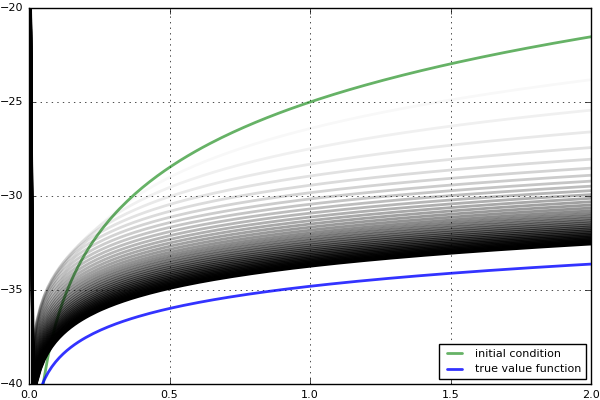

In [4]:
main()


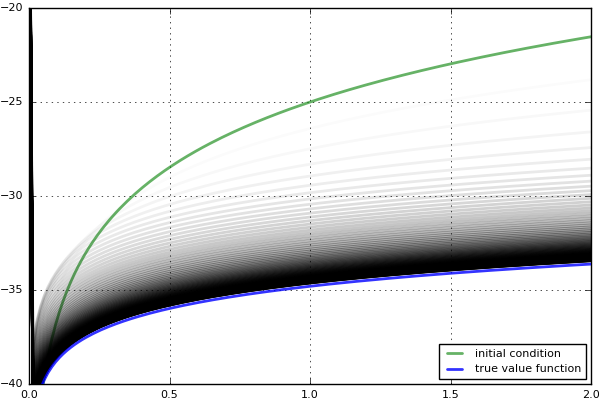

In [5]:
main2()

## Exercise1

In [8]:
Pkg.add("PlotlyJS")

INFO: Cloning cache of Blink from git://github.com/JunoLab/Blink.jl.git
INFO: Cloning cache of Codecs from git://github.com/dcjones/Codecs.jl.git
INFO: Cloning cache of Hiccup from git://github.com/JunoLab/Hiccup.jl.git
INFO: Cloning cache of HttpCommon from git://github.com/JuliaWeb/HttpCommon.jl.git
INFO: Cloning cache of HttpParser from git://github.com/JuliaWeb/HttpParser.jl.git
INFO: Cloning cache of HttpServer from git://github.com/JuliaWeb/HttpServer.jl.git
INFO: Cloning cache of Lazy from git://github.com/MikeInnes/Lazy.jl.git
INFO: Cloning cache of MbedTLS from git://github.com/JuliaWeb/MbedTLS.jl.git
INFO: Cloning cache of Mustache from git://github.com/jverzani/Mustache.jl.git
INFO: Cloning cache of Mux from git://github.com/JuliaWeb/Mux.jl.git
INFO: Cloning cache of PlotlyJS from git://github.com/spencerlyon2/PlotlyJS.jl.git
INFO: Cloning cache of WebSockets from git://github.com/JuliaWeb/WebSockets.jl.git
INFO: Installing Blink v0.3.4
INFO: Installing Codecs v0.1.5
INFO: I


7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18

Processing archive: C:\Users\taishi\.julia\v0.4\HttpParser\deps\downloads\libhttp_parser.zip

Extracting  usr\lib
Extracting  usr\lib\libhttp_parser32.dll
Extracting  usr\lib\libhttp_parser64.dll

Everything is Ok

Folders: 1
Files: 2
Size:       222605
Compressed: 77835


INFO: Building MbedTLS
INFO: Attempting to Create directory C:\Users\taishi\.julia\v0.4\MbedTLS\deps\downloads
INFO: Downloading file https://malmaud.github.io/files/mbedtls-2.1.1-r1.zip
INFO: Done downloading file https://malmaud.github.io/files/mbedtls-2.1.1-r1.zip



7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18

Processing archive: C:\Users\taishi\.julia\v0.4\MbedTLS\deps\downloads\mbedtls-2.1.1-r1.zip

Extracting  usr
Extracting  usr\bin32


INFO: Attempting to Create directory C:\Users\taishi\.julia\v0.4\MbedTLS
INFO: Directory C:\Users\taishi\.julia\v0.4\MbedTLS already created


Extracting  usr\bin32\libmbedcrypto.dll
Extracting  usr\bin32\libmbedtls.dll
Extracting  usr\bin32\libmbedx509.dll
Extracting  usr\bin64
Extracting  usr\bin64\libmbedcrypto.dll
Extracting  usr\bin64\libmbedtls.dll
Extracting  usr\bin64\libmbedx509.dll

Everything is Ok

Folders: 3
Files: 6
Size:       1441181
Compressed: 572203


INFO: Building WinRPM
INFO: Downloading https://cache.julialang.org/http://download.opensuse.org/repositories/windows:/mingw:/win32/openSUSE_13.2/repodata/repomd.xml
INFO: Downloading https://cache.julialang.org/http://download.opensuse.org/repositories/windows:/mingw:/win32/openSUSE_13.2/repodata/7085ba7bb800216bcdc1f9df3580d21be54e23c0cf3bf341052db60fddcb2874-primary.xml.gz
INFO: Downloading https://cache.julialang.org/http://download.opensuse.org/repositories/windows:/mingw:/win64/openSUSE_13.2/repodata/repomd.xml
INFO: Downloading https://cache.julialang.org/http://download.opensuse.org/repositories/windows:/mingw:/win64/openSUSE_13.2/repodata/67e7859eef89e8bf111e4c979d4a332d96552c16217acdfb38e6fd19206d4d1d-primary.xml.gz
INFO: Building Nettle
INFO: Updating WinRPM package list
INFO: Downloading https://cache.julialang.org/http://download.opensuse.org/repositories/windows:/mingw:/win32/openSUSE_13.2/repodata/repomd.xml
INFO: Downloading https://cache.julialang.org/http://download.o

In [9]:
Pkg.add("Interact")

INFO: Cloning cache of DataStructures from git://github.com/JuliaLang/DataStructures.jl.git
INFO: Cloning cache of Interact from git://github.com/JuliaLang/Interact.jl.git
INFO: Cloning cache of Reactive from git://github.com/JuliaLang/Reactive.jl.git
INFO: Installing DataStructures v0.4.4
INFO: Installing Interact v0.3.1
INFO: Installing Reactive v0.3.3
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Interact
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [14]:
Pkg.add("QuantEcon")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of QuantEcon
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [19]:
Pkg.add("Grid")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Grid
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [20]:
using QuantEcon
include("optgrowth.jl")
using PlotlyJS
using Interact

# set up the model
alpha, bet = 0.65, 0.95
gm2 = GrowthModel() 
true_sigma = (1 - alpha*bet) .* collect(gm2.grid).^alpha
w = 5 .* gm2.u(collect(gm2.grid)) .- 25  # Initial condition
sigma = get_greedy(gm2, w)
bellman(w) = bellman_operator(gm2, w)

# construct the plot with the initial condition above
layout = Layout(yaxis_range=(0, 1), xaxis_range=(0, 2),
                title="Initial condition")

t1 = scatter(x=gm2.grid, y=true_sigma, marker_color="black", line_opacity=0.8,
             name="true optimal policy")
t2 = scatter(x=gm2.grid, y=sigma, marker_color="blue", line_opacity=0.8,
             name="approximate optimal policy")

p = plot([t1, t2], layout)
display(p)

# now for n=1, 2, ..., 10 compute the policy after n VFI iterations
vf_n = Dict(0=>get_greedy(gm2, w))
for n in 1:10
    v_star = compute_fixed_point(bellman, w, max_iter=n, verbose=false)
    vf_n[n] = get_greedy(gm2, v_star)
end

# construct an interactive plot using the data we computed above
@manipulate for n in 1:10
    # update title
    relayout!(p, title="$n value function iterations")
    
    # update the y values on approximation
    restyle!(p, 2; y=(vf_n[n],))
end


LoadError: LoadError: UndefVarError: Layout not defined
while loading In[20], in expression starting on line 15